In [13]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.sparse.linalg import lsqr
from scipy.optimize import nnls, minimize

In [2]:
def d2phi(d):
    return - np.log2(d)

def phi2d(phi):
    return 2**(-phi)

def column_spread_fine(height):
    return (0.2*(height**2))**(2/5)

def column_spread_coarse(height, diffusion_coefficient):
    return 0.0032 * (height**2) / diffusion_coefficient

def fall_time(terminal_velocity, release_height):
    return release_height/terminal_velocity

def func2(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(2*np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(2*sigma_sqr))

def func(x, y, sigma_sqr, x_bar, y_bar):
    return 1/(np.pi*sigma_sqr) * np.exp(-((x - x_bar)**2 + (y - y_bar)**2)/(sigma_sqr))


def sigma_squared(height, fall_time, diff_coef, eddy_const, fall_time_thres):
    if fall_time < fall_time_thres:
        spread = column_spread_coarse(height, diff_coef)
        ss = 4*diff_coef*(fall_time + spread)
    else:
        spread = column_spread_fine(height)
        ss = ((8*eddy_const)/5) * ((fall_time + spread)**(5/2))
    if ss <=0:
        ss += 1e-9
    return ss

def landing_point(x1, z1, ux, vt):
    m = vt/ux
    return x1 - (z1/m)

def mass_dist_in_plume(dist, z_min, z_max, z_points, total_mass):
    z_norm = z_points/(z_max - z_min)
    pdf = dist.pdf(z_norm)
    pdf_sum = sum(dist.pdf(z_norm))
    norm_dist = dist.pdf(z_norm)/pdf_sum
    mass_dist = norm_dist * total_mass
    return mass_dist

def construct_dataframe(deposit, easting, northing):
    df = pd.DataFrame(deposit.T, columns=northing, index=easting)
    df.reset_index(inplace=True)
    #display(df)
    df = pd.melt(df, id_vars=["index"])
    df = df.rename(columns={"index": "Easting", "variable": "Northing", "value":"MassArea"})
    return df

def random_sample(n, df, sample_dev, K):
    transect = df[df["Northing"]==0].values
    max_point = np.argmax(transect)
    samp_x = df["Easting"].values
    return samp_x, samp_y

def part_fall_time(particle_ht, layer, ashdiam, part_density, air_density, gravity, air_viscosity):
    hz = particle_ht # height of particle above sea level
    particle_fall_time = 0.0
    
    # rho is the density of air (kg/m^3) at the elevation of the current particle
    rho = air_density * np.exp(-hz/8200.0) 
    
    #  (friction due to the air) :
    #  vtl is terminal velocity (m/s) in laminar regime RE<6
    #  vti is terminal velocity (m/s) in intermediate regime 6<RE<500
    #  vtt is terminal velocity (m/s) in turbulent regime RE>500
    
    vtl = part_density * gravity * ashdiam * ashdiam / (air_viscosity * 18.0)
    
    reynolds_number = ashdiam * rho * vtl / air_viscosity
    particle_term_vel = vtl
    temp0 = ashdiam * rho
    
    if reynolds_number >= 6.0:
        temp1 = 4.0 * gravity * gravity * part_density * part_density / (air_viscosity * 225.0 * rho)
        vti = ashdiam * (temp1 ** (1./3.)) 
        reynolds_number = temp0 * vti / air_viscosity
        particle_term_vel = vti

    # c...if intermediate RE>500 (turbulent regime), RE is calculated again considering vtt

    if reynolds_number >= 500.0:
        vtt = np.sqrt( 3.1 * part_density * gravity * ashdiam / rho)
        reynolds_number =  temp0 * vtt / air_viscosity
        particle_term_vel = vtt
    
    particle_fall_time = layer / particle_term_vel

    return (particle_fall_time, particle_term_vel)

def strat_average(average_wind_direction, average_windspeed, xspace, yspace, total_fall_time, sigma):
    temp0 = np.cos(average_wind_direction)
    temp1 = np.sin(average_wind_direction)

    xprime = xspace * temp0 + yspace * temp1
    yprime = yspace * temp0 - xspace * temp1

    temp0 = xprime - average_windspeed * total_fall_time
    demon1 = temp0 * temp0 + yprime * yprime
    demon3 = np.exp(-demon1/sigma) # where sigma is calculated for the total fall time 
    
    return demon3

In [3]:
def gaussian_stack_forward(config, globs, p, z_min, z_max, q_dist, tot_mass, u, phi):
    # Release points in column
    layer_thickness = (z_max/p)
    z = np.linspace(z_min + layer_thickness, z_max, p)
    
    d = phi2d(phi)/1000
    vv = [-part_fall_time(zk, layer_thickness, 
                          d, particle_density, 
                          globs["AIR_DENSITY"], 
                          globs["GRAVITY"], 
                          globs["AIR_VISCOSITY"])[1] for zk in z]
    ft = [part_fall_time(zk, layer_thickness, d, particle_density, globs["AIR_DENSITY"], globs["GRAVITY"], globs["AIR_VISCOSITY"])[0] for zk in z]
    
    
    # Landing points of release point centers {DEPRECATED}
    x_bar = [landing_point(0, zk, u, v) for zk, v in zip(z, vv)]

    #Mass distribution in the plume
    q_mass = mass_dist_in_plume(q_dist, z_min, z_max, z, tot_mass)
    
    q = q_mass
    
    input_data = np.asarray([z, np.asarray(q_mass), np.asarray(q), np.asarray(x_bar)]).T
    input_table = pd.DataFrame(input_data,  columns=["Release Height (z)", 
                                                     "Suspended Mass (q)", 
                                                     "Scaled Mass (q)", 
                                                     "Landing Points (x_bar)"])
    
    xx = np.linspace(-200000, 300000, 501)
    x_range = xx[-1] - xx[0]
    yy = np.linspace(-250000, 250000, 501)
    X, Y = np.meshgrid(xx, yy)
    dep_mass = np.zeros(X.shape)
    sus_mass = []
    sig = []

    for k, zh in enumerate(z):
        # Gaussian dispersal
        s_sqr = sigma_squared(zh, sum(ft[:k+1]), 
                              config["DIFFUSION_COEFFICIENT"], 
                              config["EDDY_CONST"], 
                              config["FALL_TIME_THRESHOLD"])
        dist = strat_average(0, u, X, Y, sum(ft[:k+1]), s_sqr)
        
        dep_mass += (q[k]/(s_sqr*np.pi))*dist
        sig.append(s_sqr)
    dep_df = construct_dataframe(dep_mass, xx, yy)   
    return input_table, dep_df, sig, vv, ft

In [4]:
def beta_function(z, a, b, h0, h1):
    return beta.pdf(z, a, b, h0, h1)

def beta_transform(a_star, b_star, h0_star, h1_star, tot_mass, z):
    a, b, h0, h1 = param_transform(a_star, b_star, h0_star, h1_star)
#     a = np.exp(a_star)
#     b = np.exp(b_star)
#     h1 = 45000*np.exp(-np.exp(-h1_star))
#     h0 = h1*np.exp(-np.exp(-h0_star))
    dist = beta.pdf(z, a, b, h0, h1)
    return (dist/sum(dist))*tot_mass

def param_transform(a_star, b_star, h0_star, h1_star):
    a = np.exp(a_star)
    b = np.exp(b_star)
    h1 = 45000*np.exp(-np.exp(-h1_star))
    h0 = h1*np.exp(-np.exp(-h0_star))
    return a, b, h0, h1

def beta_sse(k, A, z, m, tot_mass):
     return sum((np.matmul(A, beta_transform(*k, tot_mass, z)) - m) ** 2)


def gaussian_stack_inversion(config, globs, samp_df, n, p, z_min, z_max, tot_mass, u, phi, solver=None):
    # Release points in column

    layer_thickness = (z_max/p)
    z = np.linspace(z_min + layer_thickness, z_max, p)

    d = phi2d(phi)/1000
    vv = [-part_fall_time(zk, layer_thickness, d, particle_density, 
                          globs["AIR_DENSITY"], 
                          globs["GRAVITY"], 
                          globs["AIR_VISCOSITY"])[1] for zk in z]
    ft = [part_fall_time(zk, layer_thickness, d, particle_density, 
                          globs["AIR_DENSITY"], 
                          globs["GRAVITY"], 
                          globs["AIR_VISCOSITY"])[0] for zk in z]
    
    # Landing points of release point centers
    x_bar = [landing_point(0, zk, u, vv[i]) for i, zk in enumerate(z)]
    
    samp_x = samp_df['Easting'].values
    samp_y = samp_df["Northing"].values
    m = samp_df["MassArea"].values

    A = np.zeros((n,p))
    for i in range(n):
        for k in range(p):
            s_sqr = sigma_squared(z[k], sum(ft[:k+1]), 
                                  config["DIFFUSION_COEFFICIENT"], 
                                  config["EDDY_CONST"], 
                                  config["FALL_TIME_THRESHOLD"])
            dist = strat_average(0, u, samp_x[i], samp_y[i], sum(ft[:k+1]), s_sqr)
            A[i,k] = (1/(s_sqr*np.pi))*dist
    coefficient_matrix = pd.DataFrame(A)
    if n == p:
        det = np.linalg.det(A)
    else: 
        det = None
    rank = np.linalg.matrix_rank(A)
    
    if solver=='lsqr':
        lst_q = lsqr(A, m, damp=1e-10)
        q_inv_mass = np.asarray(lst_q[0])
    else:
        k0 = np.array([1, 1, 1, 1], dtype=np.float64)
        def func(k): return beta_sse(k, A, z, m, tot_mass)
        sol = minimize(func, k0, method='Nelder-Mead')
        params = param_transform(*sol.x)
        print("a* = %.5f\tb* = %.5f\th0* = %.5f\th1* = %.5f"%(sol.x[0], sol.x[1], sol.x[2], sol.x[3]))
        print("a = %.5f\tb = %.5f\th0 = %.5f\th1 = %.5f"%params)
        print("Success: " + str(sol.success) + ", " + str(sol.message))
        if(hasattr(sol, "nit")):
            print("Iterations: " + str(sol.nit))
        q_inv_mass = beta_transform(*sol.x, tot_mass, z)
    
    inversion_data = np.asarray([np.asarray(z), q_inv_mass]).T
    inversion_table = pd.DataFrame(inversion_data, columns=["Height", "Suspended Mass"])
    return inversion_table, coefficient_matrix, det, rank

In [5]:
wind = "med"
phi = "mid"

wind_dict = {
    "no":0.001,
    "med":10,
    "hi":20
}

filename = 'wind_phi_trial/' + phi + '_phi_' + wind + '_wind.txt'
t2_df, _, _, _ = io.read_tephra2(filename)
# display(t2_df)

#savefile tag
tag = 'pr71/' + phi + '_phi_' + wind + '_wind'

#infile tag
in_tag = 'wind_phi_trial/' + phi + '_phi_' + wind + '_wind'


config = {}
with open("wind_phi_trial/test_config_%s_phi.txt"%phi) as f:
    for line in f:
        (key, val) = line.split()
        config[str(key)] = float(val)
        
config["WIND_SPEED"] = wind_dict[wind]

config["COL_STEPS"] = int(config["COL_STEPS"])
config["PART_STEPS"] = int(config["PART_STEPS"])

globs = {
    "LITHIC_DIAMETER_THRESHOLD": 7.,
    "PUMICE_DIAMETER_THRESHOLD": -1.,
    "AIR_VISCOSITY": 0.000018325,
    "AIR_DENSITY":  1.293,
    "GRAVITY": 9.81,
}

if config["MAX_GRAINSIZE"] > globs["LITHIC_DIAMETER_THRESHOLD"]:
    particle_density = config["LITHIC_DENSITY"]
elif config["MAX_GRAINSIZE"] < globs["PUMICE_DIAMETER_THRESHOLD"]:
    particle_density = config["PUMICE_DENSITY"]
else:
    particle_density = config["LITHIC_DENSITY"] - (config["LITHIC_DENSITY"] - config["PUMICE_DENSITY"]) * (config["MAX_GRAINSIZE"] -globs["LITHIC_DIAMETER_THRESHOLD"])/( globs["PUMICE_DIAMETER_THRESHOLD"] -  globs["LITHIC_DIAMETER_THRESHOLD"])

config["PARTICLE_DENSITY"] = particle_density
    
display(config)
display(globs)

{'VENT_EASTING': 0.0,
 'VENT_NORTHING': 0.0,
 'VENT_ELEVATION': 1.0,
 'PLUME_HEIGHT': 30000.0,
 'ALPHA': 3.0,
 'BETA': 2.0,
 'ERUPTION_MASS': 10000000000.0,
 'MAX_GRAINSIZE': 0.5,
 'MIN_GRAINSIZE': 1.5,
 'MEDIAN_GRAINSIZE': 1.0,
 'STD_GRAINSIZE': 1.0,
 'EDDY_CONST': 0.04,
 'DIFFUSION_COEFFICIENT': 1000.0,
 'FALL_TIME_THRESHOLD': 3600.0,
 'LITHIC_DENSITY': 2700.0,
 'PUMICE_DENSITY': 1024.0,
 'COL_STEPS': 100,
 'PART_STEPS': 1,
 'PLUME_MODEL': 2.0,
 'WIND_SPEED': 10,
 'PARTICLE_DENSITY': 1338.25}

{'LITHIC_DIAMETER_THRESHOLD': 7.0,
 'PUMICE_DIAMETER_THRESHOLD': -1.0,
 'AIR_VISCOSITY': 1.8325e-05,
 'AIR_DENSITY': 1.293,
 'GRAVITY': 9.81}

<IPython.core.display.Javascript object>


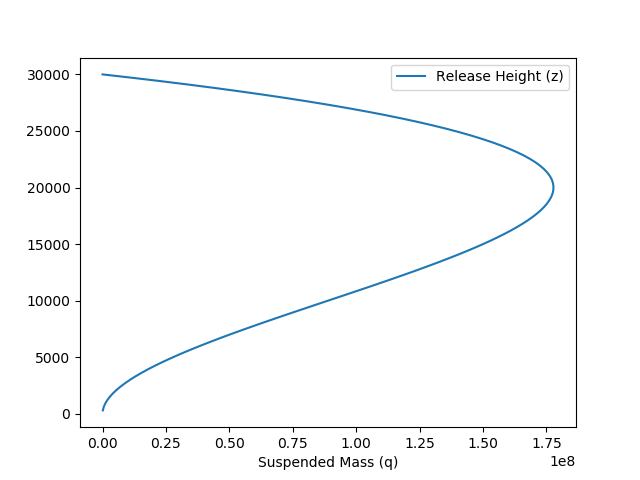

In [6]:
q_dist = beta(config["ALPHA"],config["BETA"])

input_table, gsm_df, sig, vv, tft= gaussian_stack_forward(config, globs, 
                                                          int(config["COL_STEPS"]), 0, 
                                                          config["PLUME_HEIGHT"], 
                                                          q_dist,
                                                          config["ERUPTION_MASS"], 
                                                          config["WIND_SPEED"], 
                                                          config["MAX_GRAINSIZE"])

input_table.plot("Suspended Mass (q)", "Release Height (z)")
plt.show()

In [7]:
threshold = 10e-5

t2_df = t2_df[t2_df["MassArea"] > threshold]
t2_df = t2_df[t2_df["Easting"] < 200000]
t2_df = t2_df[t2_df["Easting"] > -200000]
t2_df = t2_df[t2_df["Northing"] < 100000]
t2_df = t2_df[t2_df["Northing"] > -100000]


gsm_df = gsm_df[gsm_df["MassArea"] > threshold]
gsm_df = gsm_df[gsm_df["Easting"] < 200000]
gsm_df = gsm_df[gsm_df["Easting"] > -200000]
gsm_df = gsm_df[gsm_df["Northing"] < 100000]
gsm_df = gsm_df[gsm_df["Northing"] > -100000]
#display(gsm_df)
#display(t2_df)

piv_data = t2_df.pivot("Northing", "Easting", "MassArea")
gsm_piv = gsm_df.pivot("Northing", "Easting", "MassArea")


93


<IPython.core.display.Javascript object>


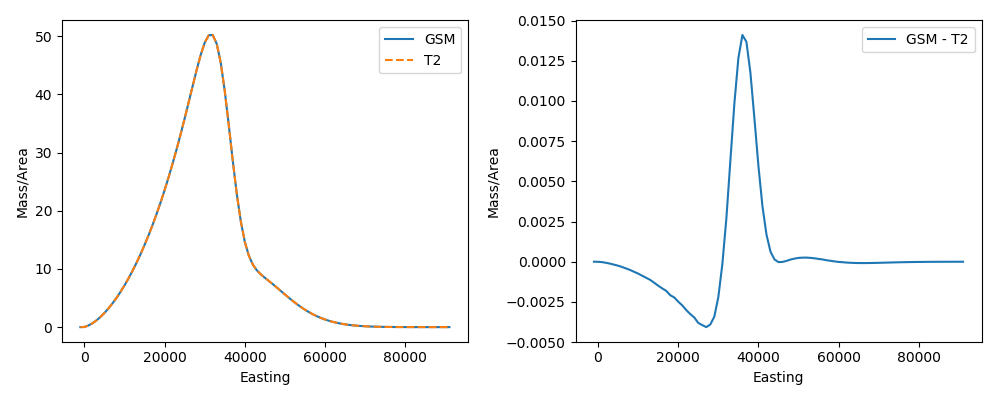

In [8]:
t2line = t2_df[t2_df["Northing"]==0]
#display(t2line)


gsm_line = gsm_df[gsm_df["Northing"]==0]
print(len(gsm_line))

fig, axs = plt.subplots(1,2, figsize=(
        10, 4), facecolor='w', edgecolor='k')

ax1, ax2 = axs.ravel()


ax1.plot(gsm_line["Easting"], gsm_line["MassArea"], label="GSM")
ax1.plot(t2line["Easting"], t2line["MassArea"], "--", label="T2")
ax1.legend()
ax1.set_xlabel("Easting")
ax1.set_ylabel("Mass/Area")
# plt.show()



ax2.plot(gsm_line["Easting"], gsm_line["MassArea"] - t2line["MassArea"], label="GSM - T2")
# plt.plot(t2line["Easting"], t2line["MassArea"], "--", label="T2")
ax2.legend()
ax2.set_xlabel("Easting")
ax2.set_ylabel("Mass/Area")
# plt.show()
plt.tight_layout()
plt.savefig(tag + "_transects.png", dpi=200, format='png')

In [9]:
def sample(df, n, weight="MassArea", alpha=0.5):
    weights = df[weight].copy() # Get values to be used as weights
    weights = weights**(alpha) # Apply scaling factor as w^alpha
    probs = weights/np.sum(weights) # Normalise to sum up to one
    chosen = np.random.choice(df.index, n, replace=False, p=probs) # Randomly choose n points
    return df.loc[chosen]

array([121979, 133018, 141010, 127971, 123981, 125462, 134999, 115971,
       129015, 126484, 128985, 124981, 115436, 134493, 117456, 124976,
       123486, 112945, 127497, 125458, 132035, 129020, 138528, 116992,
       119456, 127987, 129501, 119000, 123990, 113956], dtype=int64)

<IPython.core.display.Javascript object>


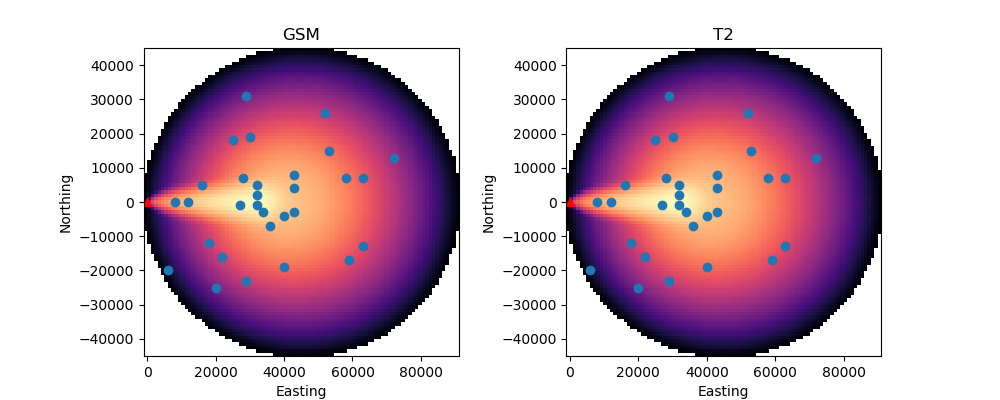

In [10]:
n=30

lower_lim = np.nanmin(gsm_piv.values)
upper_lim = np.nanmax(gsm_piv.values)

gsm_sample = sample(gsm_df, n, alpha=.3).copy()
display(gsm_sample.index.values)

t2_sample = t2_df.loc[gsm_sample.index]

fig, axs = plt.subplots(1,2, figsize=(
        10, 4), facecolor='w', edgecolor='k')

ax1, ax2 = axs.ravel()

im1 = ax1.imshow(np.log10(gsm_piv.values),
                 extent=[gsm_piv.columns.min(), gsm_piv.columns.max(),
                       gsm_piv.index.min(), gsm_piv.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim),
                 vmax=np.log10(upper_lim))

ax1.scatter(gsm_sample["Easting"], gsm_sample["Northing"])
ax1.plot(0,0,"r^")
ax1.set_xlabel("Easting")
ax1.set_ylabel("Northing")
ax1.set_title("GSM")
im2 = ax2.imshow(np.log10(piv_data.values),
                 extent=[piv_data.columns.min(), piv_data.columns.max(),
                       piv_data.index.min(), piv_data.index.max()],
                 origin='lower',
                 cmap="magma", alpha=1,
                 vmin=np.log10(lower_lim),
                 vmax=np.log10(upper_lim))
ax2.set_title("T2")
ax2.scatter(t2_sample["Easting"], t2_sample["Northing"])
ax2.plot(0,0,"r^")
ax2.set_xlabel("Easting")
ax2.set_ylabel("Northing")


plt.show()
plt.savefig(tag + "_samps.png", dpi=200, format='png')

GSM
a* = 1.09802	b* = 0.69236	h0* = -2.17759	h1* = 0.90185
a = 2.99824	b = 1.99843	h0 = 4.40887	h1 = 29989.44133
Success: True, Optimization terminated successfully.
Iterations: 196

TEPHRA2
a* = 1.09818	b* = 0.69331	h0* = -2.17538	h1* = 0.90268
a = 2.99871	b = 2.00032	h0 = 4.49699	h1 = 29999.55556
Success: True, Optimization terminated successfully.
Iterations: 195


<IPython.core.display.Javascript object>


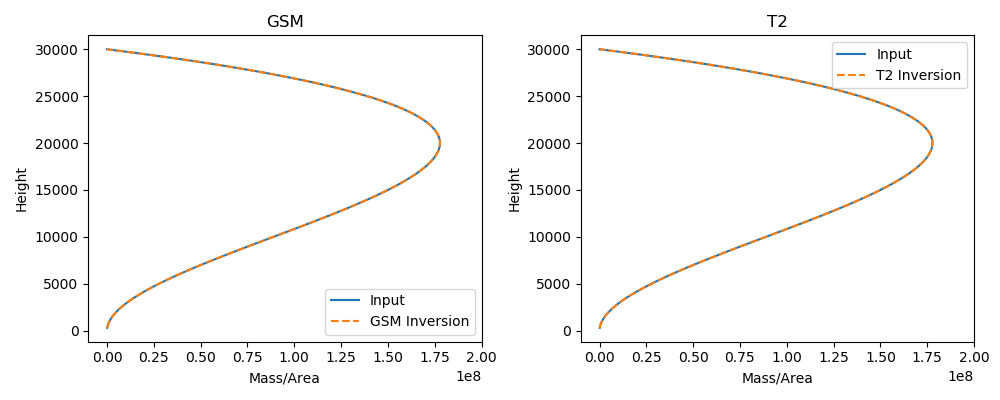

In [11]:
print("GSM")
inversion_table_gsm, _, _, _ = gaussian_stack_inversion(config, globs, gsm_sample, n, 
                                                          int(config["COL_STEPS"]), 0, 
                                                          config["PLUME_HEIGHT"], 
                                                          config["ERUPTION_MASS"], 
                                                          config["WIND_SPEED"], 
                                                          config["MAX_GRAINSIZE"],
                                                          solver=None)

print("\nTEPHRA2")
inversion_table_t2, _, _, _ = gaussian_stack_inversion(config, globs, t2_sample, n, 
                                                          int(config["COL_STEPS"]), 0, 
                                                          config["PLUME_HEIGHT"], 
                                                          config["ERUPTION_MASS"], 
                                                          config["WIND_SPEED"], 
                                                          config["MAX_GRAINSIZE"],
                                                          solver=None)



fig, axs = plt.subplots(1,2, figsize=(
        10, 4), facecolor='w', edgecolor='k')

ax1, ax2 = axs.ravel()

ax1.plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
ax1.plot(inversion_table_gsm["Suspended Mass"], inversion_table_gsm["Height"], '--', label="GSM Inversion")
ax1.legend()
ax1.set_title("GSM")
ax1.set_ylabel("Height")
ax1.set_xlabel("Mass/Area")

ax2.plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
ax2.plot(inversion_table_t2["Suspended Mass"], inversion_table_t2["Height"], '--', label="T2 Inversion")
ax2.legend()
ax2.set_title("T2")
ax2.set_ylabel("Height")
ax2.set_xlabel("Mass/Area")


ax2.set_xlim([-10000000,2e8])
ax1.set_xlim([-10000000,2e8])

plt.tight_layout()
# plt.show()
plt.savefig(tag + "_inversions.png", dpi=200, format='png')


<IPython.core.display.Javascript object>


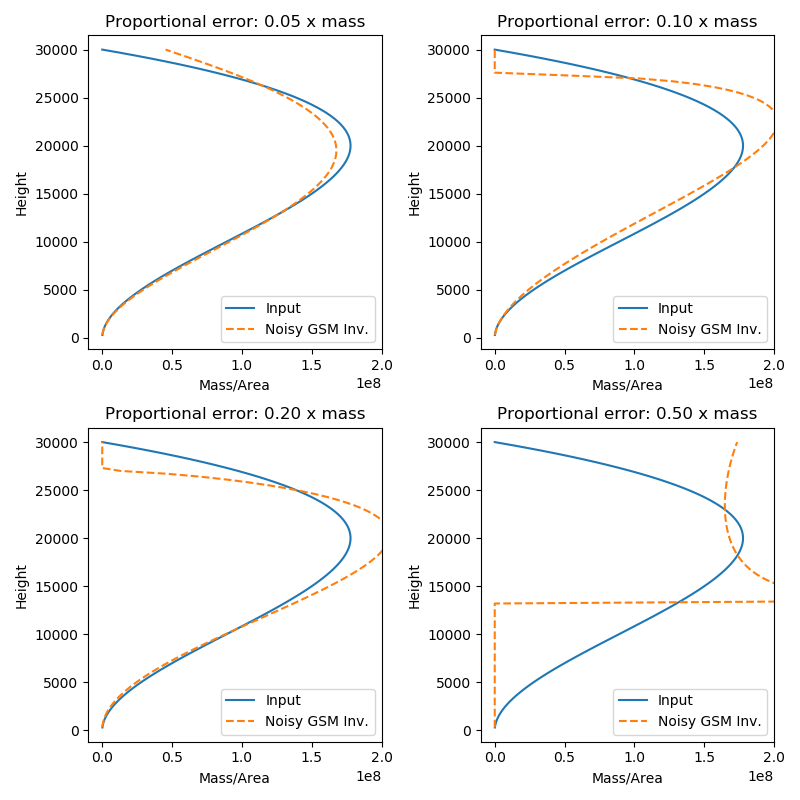


Noise: 0.05
a* = 1.10814	b* = 0.86319	h0* = -2.72015	h1* = 1.14012
a = 3.02872	b = 2.37070	h0 = 0.00833	h1 = 32683.84853
Success: True, Optimization terminated successfully.
Iterations: 233

Noise: 0.1
a* = 1.03258	b* = 0.32787	h0* = -3.46147	h1* = 0.69835
a = 2.80831	b = 1.38800	h0 = 0.00000	h1 = 27364.75124
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 489

Noise: 0.2
a* = 1.13448	b* = 0.52933	h0* = -5.35249	h1* = 0.67574
a = 3.10956	b = 1.69779	h0 = 0.00000	h1 = 27055.26115
Success: True, Optimization terminated successfully.
Iterations: 255

Noise: 0.5
a* = -0.25044	b* = -0.97147	h0* = -0.07657	h1* = 1.91823
a = 0.77846	b = 0.37853	h0 = 13200.00230	h1 = 38853.41767
Success: False, Maximum number of function evaluations has been exceeded.
Iterations: 461


In [12]:
def add_noise(val,prop):
    return val+np.random.normal(scale=prop*val)

noises = [.05, .1, .2, .5]

fig, axs = plt.subplots(2,2, figsize=(
        8, 8), facecolor='w', edgecolor='k')

axs = axs.ravel()
for i, noise in enumerate(noises):
    print("\nNoise: " + str(noise))
    gsm_noise = gsm_sample.copy()
    gsm_noise['MassArea'] = gsm_sample.apply(lambda x: add_noise(x['MassArea'],noise),axis=1)
    gsm_noise["noise"] = gsm_sample['MassArea'] - gsm_noise['MassArea']
#     axs[i].scatter(gsm_noise["Easting"], gsm_noise["noise"])
    inversion_table_gsm, _, _, _ = gaussian_stack_inversion(config, globs, gsm_noise, n, 
                                                              config["COL_STEPS"], 0, 
                                                              config["PLUME_HEIGHT"], 
                                                              config["ERUPTION_MASS"], 
                                                              config["WIND_SPEED"], 
                                                              config["MAX_GRAINSIZE"],
                                                              solver=None)
    axs[i].plot(input_table["Suspended Mass (q)"], input_table["Release Height (z)"], label="Input")
    axs[i].plot(inversion_table_gsm["Suspended Mass"], inversion_table_gsm["Height"], '--', label="Noisy GSM Inv.")
    axs[i].legend()
    axs[i].set_title("Proportional error: %.2f x mass"%noise)
    axs[i].set_ylabel("Height")
    axs[i].set_xlabel("Mass/Area")
    axs[i].set_xlim([-10000000,2e8])
plt.tight_layout()

plt.savefig(tag + "_noise.png", dpi=200, format='png')
